In [15]:
import pandas as pd

# Load CSV
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/bootcamp/1429_1.csv')

# Display first few rows
print(df.columns)
df.head()

# Text Cleaning and Preprocessing
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

# Download NLTK resources if not already present
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()



def clean_text(text):
    if pd.isnull(text):
        return ''
    # Lowercase
    text = text.lower()
    # Remove punctuation and numbers
    text = re.sub(r'[^a-z\s]', '', text)
    # Tokenize and remove stopwords
    tokens = [word for word in text.split() if word not in stop_words]
    # Lemmatize
    tokens = [lemmatizer.lemmatize(word) for word in tokens]
    return ' '.join(tokens)

# Apply cleaning to the 'reviews.text' column after handling missing values
if 'reviews.text' in df.columns:
    df['reviews.text'] = df['reviews.text'].fillna('') # Handle missing values
    df['cleaned_text'] = df['reviews.text'].apply(clean_text)
else:
    print('Column reviews.text not found in DataFrame')

# Display cleaned text
print(df[['reviews.text', 'cleaned_text']].head())

/tmp/ipython-input-15-3007880078.py:4: DtypeWarning: Columns (1,10) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/bootcamp/1429_1.csv')
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


Index(['id', 'name', 'asins', 'brand', 'categories', 'keys', 'manufacturer',
       'reviews.date', 'reviews.dateAdded', 'reviews.dateSeen',
       'reviews.didPurchase', 'reviews.doRecommend', 'reviews.id',
       'reviews.numHelpful', 'reviews.rating', 'reviews.sourceURLs',
       'reviews.text', 'reviews.title', 'reviews.userCity',
       'reviews.userProvince', 'reviews.username'],
      dtype='object')
                                        reviews.text  \
0  This product so far has not disappointed. My c...   
1  great for beginner or experienced person. Boug...   
2  Inexpensive tablet for him to use and learn on...   
3  I've had my Fire HD 8 two weeks now and I love...   
4  I bought this for my grand daughter when she c...   

                                        cleaned_text  
0  product far disappointed child love use like a...  
1  great beginner experienced person bought gift ...  
2  inexpensive tablet use learn step nabi thrille...  
3  ive fire hd two week love tab

In [27]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(max_features=5000)
X = vectorizer.fit_transform(df['cleaned_text'])


tfidf_df = pd.DataFrame(X.toarray())
feature_names = vectorizer.get_feature_names_out()[:20]


print(tfidf_df.shape)
print(tfidf_df.head())

(34660, 5000)
   0         1         2     3     4     5     6     7     8     9     ...  \
0   0.0  0.315374  0.000000   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   
1   0.0  0.000000  0.000000   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   
2   0.0  0.000000  0.000000   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   
3   0.0  0.000000  0.102577   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   
4   0.0  0.000000  0.000000   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   

   4990  4991  4992  4993  4994  4995  4996  4997  4998  4999  
0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  
1   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  
2   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  
3   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  
4   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  

[5 rows x 5000 columns]


In [28]:
# Label sentiment from ratings
def label_sentiment(rating):
    if rating >= 4:
        return 'positive'
    elif rating == 3:
        return 'neutral'
    else:
        return 'negative'

# Apply sentiment labeling to the same DataFrame used for TF-IDF
# Filter df to include only rows with non-empty cleaned_text
df_filtered = df[df['cleaned_text'].str.strip() != ''].copy()

df_filtered['label'] = df_filtered['reviews.rating'].apply(label_sentiment)

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
print(df_filtered.columns.tolist())


# Re-generate y from the filtered DataFrame
le = LabelEncoder()
y = le.fit_transform(df_filtered['label'])

# Use the filtered DataFrame index to match X
X_filtered = X[df_filtered.index]

X_train, X_test, y_train, y_test = train_test_split(X_filtered, y, test_size=0.2, random_state=42)



['id', 'name', 'asins', 'brand', 'categories', 'keys', 'manufacturer', 'reviews.date', 'reviews.dateAdded', 'reviews.dateSeen', 'reviews.didPurchase', 'reviews.doRecommend', 'reviews.id', 'reviews.numHelpful', 'reviews.rating', 'reviews.sourceURLs', 'reviews.text', 'reviews.title', 'reviews.userCity', 'reviews.userProvince', 'reviews.username', 'cleaned_text', 'label']


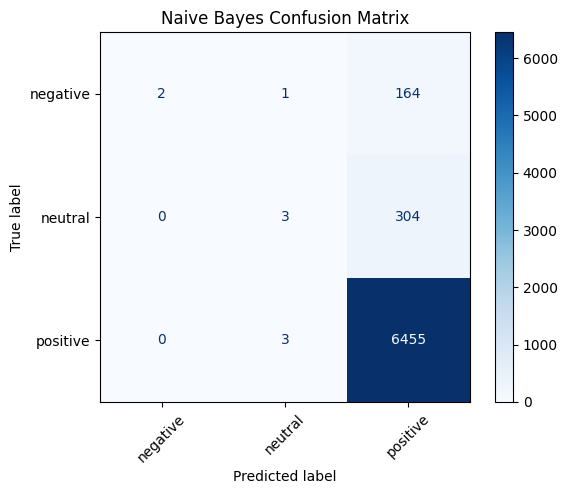

In [29]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix

# Naive Bayes
nb = MultinomialNB()
nb.fit(X_train, y_train)
nb_preds = nb.predict(X_test)
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt

ConfusionMatrixDisplay.from_predictions(
    y_test,
    nb_preds,
    display_labels=le.classes_,  # Use actual label names
    cmap='Blues',
    xticks_rotation=45
)
plt.title("Naive Bayes Confusion Matrix")
plt.show()


In [31]:
from sklearn.metrics import classification_report

print("Classification Report:")
print(classification_report(y_test, nb_preds, target_names=le.classes_))
from sklearn.metrics import accuracy_score

accuracy = accuracy_score(y_test, nb_preds)
print(f"Accuracy: {accuracy:.4f}")


Classification Report:
              precision    recall  f1-score   support

    negative       1.00      0.01      0.02       167
     neutral       0.43      0.01      0.02       307
    positive       0.93      1.00      0.96      6458

    accuracy                           0.93      6932
   macro avg       0.79      0.34      0.34      6932
weighted avg       0.91      0.93      0.90      6932

Accuracy: 0.9319


In [32]:
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer

nltk.download('vader_lexicon')
sia = SentimentIntensityAnalyzer()

def vader_sentiment(text):
    score = sia.polarity_scores(str(text))['compound']
    if score >= 0.05:
        return 'positive'
    elif score <= -0.05:
        return 'negative'
    else:
        return 'neutral'

vader_preds = test_texts.apply(vader_sentiment)


[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


NameError: name 'test_texts' is not defined